In many cases, it's necessary to store data from Google Earth Engine (GEE) locally for offline analysis and integration with other projects and tools. This notebook demonstrates techniques for saving time series data and images to a local hard drive, with similar examples found throughout the book.

A critical factor in downloading data from GEE is its limitation on data size per download request. Downloading and processing large datasets locally negates the advantage of GEE, which is designed to accelerate data processing through its advanced infrastructure.

GEE limits image downloads to a maximum size of 32 MB or a maximum grid dimension of 10,000 pixels.

In [8]:
# Import modules
import ee
import requests
import io
import json
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpd
from matplotlib.colors import rgb2hex


In [9]:
# Authenticate GEE
#ee.Authenticate()

# Initialize GEE
ee.Initialize()

## Select region for tutorial


In [10]:
# Read US watersheds using hydrologic unit codes (HUC)
watersheds = ee.FeatureCollection("USGS/WBD/2017/HUC12")
mcdowell_creek = watersheds.filter(ee.Filter.eq('huc12', '102701010204')).first()
watershed_point = ee.Geometry.Point([-96.556316, 39.084535])

# Create mask for the region
mask = ee.Image.constant(1).clip(mcdowell_creek).mask()


## Raster data

### Save geotiff image

In this example we will request a small georeferenced image and then save it in .geotiff format. We will also read the image back into the notebook.

In [11]:
# Import map from Digital Elevation Model (DEM)
srtm = ee.Image('CGIAR/SRTM90_V4')


In [12]:
# Clip elevation map to boundaries of McDowell Creek
# and mask points outside the watershed boundary
mcdowell_creek_elv = srtm.clip(mcdowell_creek).mask(mask)


In [13]:
# Define coordinate reference system
crs = 32614 # UTM14 Projected coordinates in meters
#crs = 4326 # WGS84 Geographic coordinates in degrees


# Get URL link to full image
image_url = mcdowell_creek_elv.getDownloadUrl({
    'region': mcdowell_creek.geometry(),
    'scale':30,
    'crs': f'EPSG:{crs}',
    'format': 'GEO_TIFF'
})

# Display clickable URL link to download TIFF image
print(image_url)


https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a3c4c75d3ef68b3a9f43b5b1f66fab2a-8e5a43ff7247a0f523a367d9e6d98265:getPixels


In [14]:
# Request data using URL and save data as a new GeoTiff file
response = requests.get(image_url)

# Write file to disk
filename = '../outputs/mc_dowell_creek_elevation.tif'
with open(filename, 'wb') as f:
    f.write(response.content)
    

In [15]:
# Read GeoTiff file using the Xarray package
raster = xr.open_dataarray(filename).squeeze()


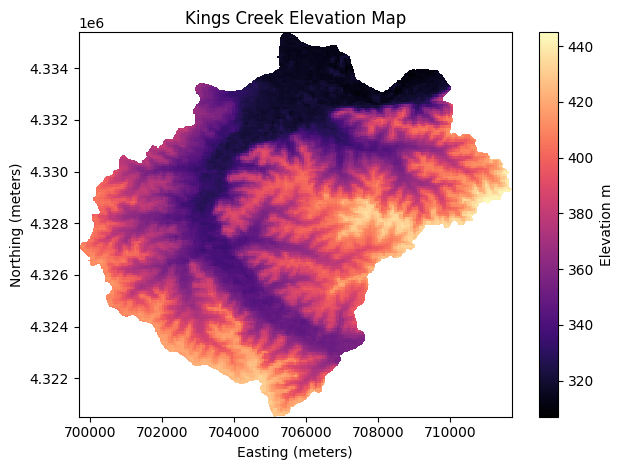

In [16]:
# Create a figure
raster.plot(cmap='magma', cbar_kwargs={'label':'Elevation m'});
plt.title('Kings Creek Elevation Map')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.tight_layout()
plt.show()


### In-memory GeoTiff

Sometimes we simply want to retrieve an image and plot it, without necessarily saving it into our local drive.

If the code below does not work, try installating the `rioxarray` package using `!pip install rioxarray`, which extends `xarray` and allows it to use the `rasterio engine` to read bytes file.

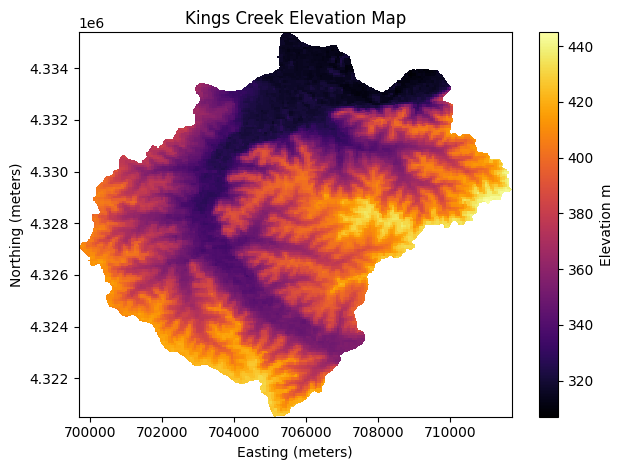

In [18]:
# Open temporary file in memory, save the content 
# of the request (this is the geotiff image) in a temporary file,
# then read the temporary file and plot the map.
with io.BytesIO(response.content) as memory_file:
    raster = xr.open_dataarray(memory_file, engine='rasterio').squeeze()
    
    # Create plot while the file is open
    raster.plot(cmap='inferno', cbar_kwargs={'label':'Elevation m'});
    plt.title('Kings Creek Elevation Map')
    plt.xlabel('Easting (meters)')
    plt.ylabel('Northing (meters)')
    plt.tight_layout()
    plt.show()
    

### Handy function to save GeoTiffs

Since this is a common operation, let's wrap the code we wrote above into a function.

In [17]:
def save_geotiff(ee_image, filename, crs, scale, geom):
    """
    Function to save images from Google Earth Engine into local hard drive.
    """
    image_url = ee_image.getDownloadUrl({
    'region': geom,
    'scale':scale,
    'crs': f'EPSG:{crs}',
    'format': 'GEO_TIFF'})
    
    # Request data using URL and save data as a new GeoTiff file
    response = requests.get(image_url)
    with open(filename, 'wb') as f:
        f.write(response.content)
        return print(f'Image {filename} saved.')
    

### Get Numpy array

Sometimes instead of the georeferenced image we want the raw data in the form of a Numpy array, so that we can further process the data in Python.

In [19]:
# Use the requests method to read image
numpy_array_url = mcdowell_creek_elv.getDownloadUrl({'crs': f'EPSG:{crs}',
                                                     'scale':30,
                                                     'format': 'NPY'})
response = requests.get(numpy_array_url )
elev_array = np.load(io.BytesIO(response.content), encoding='bytes').astype(np.float64)
print(elev_array)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


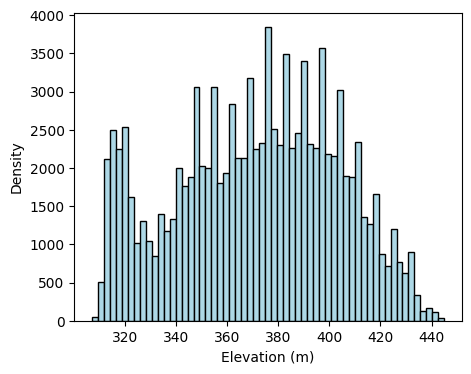

In [33]:
# Convert zero values in the mask to NaN
idx_zero = elev_array == 0
elev_array[idx_zero] = np.nan

# Create histogram of elevation
plt.figure(figsize=(5,4))
plt.hist(elev_array.flatten(), 
         bins='scott', 
         facecolor='lightblue', edgecolor='k');
plt.xlabel('Elevation (m)')
plt.ylabel('Density')
plt.show()


In [34]:
print('Array dimensions:', elev_array.shape)
print('Total pixels:', elev_array.size)

Array dimensions: (496, 401)
Total pixels: 198896


### Save thumbnail image

A thumbnail image is good for display purposes. This is not the actual, high-resolution image. This image does not have any elevation data or geographic coordinates. The color of each pixel was assigned according to the colormap and range of values provided when requesting the thumbnail image.

In [35]:
# Create the url associated to the Image you want
cmap = [rgb2hex(c) for c in plt.get_cmap('magma').colors]
thumbnail_url = mcdowell_creek_elv.getThumbUrl({'min': 300,
                                      'max': 450,
                                      'dimensions': 512,
                                      'palette': cmap})

# Print URL
print(thumbnail_url)


https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f766af93b23eddb9c6dfc16a16b2dc33-8904153edffc111c602c82500a6f915f:getPixels


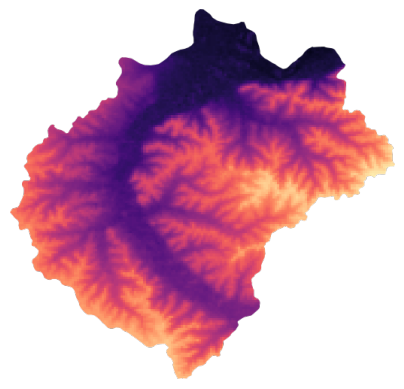

In [36]:
# Display a thumbnail of elevation map
response = requests.get(thumbnail_url )
img = plt.imread(io.BytesIO(response.content))
plt.imshow(img, cmap='magma')
plt.axis('off')
plt.savefig('../outputs/kings_creek_thumbnail.jpg')
plt.show()


## Vector data

### Get Feature coordinates into Pandas DataFrame

In this example we will simply access the latitude and longitude fields of a Kansas county.

In [37]:
# US Counties dataset
US_counties = ee.FeatureCollection("TIGER/2018/Counties") 

# '20161' is the ID for Riley county in Kansas
county = US_counties.filter(ee.Filter.eq('GEOID','20161'))

# Get coordinates of the county geometryand put them in a dataframe for easy data handling.
df = pd.DataFrame(county.first().getInfo()['geometry']['coordinates'][0])
df.columns = ['lon','lat']
df.head()


,lon,lat
0,-96.961683,39.220095
1,-96.961369,39.220095
2,-96.956566,39.220005
3,-96.954188,39.220005
4,-96.952482,39.220005


### Save data in tabular format

In this example the goal is to request temporal soil moisture data, convert it into a Pandas DataFrame, and then save it as a comma-separated value file.

In [38]:
# Load SMAP product (3-hour resolution)
smap = ee.ImageCollection("NASA/SMAP/SPL4SMGP/007").filterDate('2018-01-01','2018-01-31')

# Select rootzone soil moisture band
sm_rootzone = smap.select('sm_rootzone')

# Get rootzone soil moisture for watershed point
watershed_sm = sm_rootzone.getRegion(watershed_point, scale=1).getInfo()


In [39]:
# Convert output into a Pandas Dataframe
df = pd.DataFrame(watershed_sm[1:])
df.columns = watershed_sm[0]
df['time'] = pd.to_datetime(df['time'], unit='ms')
df.head(3)


,id,longitude,latitude,time,sm_rootzone
0,20180101_0130,-96.556312,39.084535,2018-01-01 01:30:00,0.297576
1,20180101_0430,-96.556312,39.084535,2018-01-01 04:30:00,0.297541
2,20180101_0730,-96.556312,39.084535,2018-01-01 07:30:00,0.297562


In [40]:
# Save Dataframe to local drive
df.to_csv('../outputs/smap_rootzone_2018.csv', index=False)


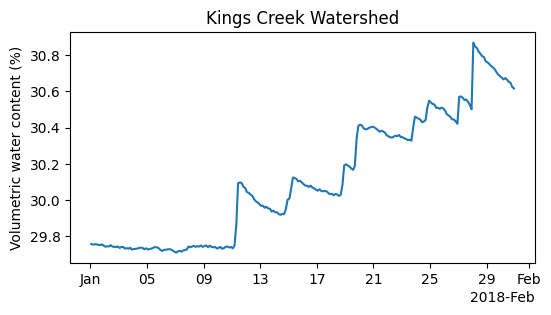

In [41]:
# Create figure to visualize data
date_fmt = mpd.ConciseDateFormatter(mpd.AutoDateLocator())
plt.figure(figsize=(6,3))
plt.title('Kings Creek Watershed')
plt.plot(df['time'], df['sm_rootzone']*100)
plt.ylabel('Volumetric water content (%)')
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.show()


### Save Feature as geoJSON

We will save a polygon feature representing the boundary of the McDowell Creek small watershed in central Kansas as a geoJSON file.

In [42]:
# Convert the feature to a GeoJSON string
feature_info = mcdowell_creek.getInfo()  # Retrieves the information about the feature

# Save the GeoJSON string to a file
with open('../outputs/kings_creek_from_gee.geojson', 'w') as file:
    # Convert dictionary to a GeoJSON string and save it
    file.write(json.dumps(feature_info))
    

In this example we will save the boundary of the state of Kansas.

In [56]:
# Read US states
US_states = ee.FeatureCollection("TIGER/2018/States")

# Select Kansas
state = US_states.filter(ee.Filter.inList('NAME',['Kansas']))

# Retrieves the information about the feature
state_info = state.getInfo()  

# Save the GeoJSON string to a file
with open('../outputs/kansas_bnd_from_gee.geojson', 'w') as file:
    
    # Convert dictionary to a GeoJSON string and save it
    file.write(json.dumps(feature_info))


### Save FeatureCollection as shapefile 

This section requires the GeoPandas library.

In [43]:
# Import GeoPandas
import geopandas as gpd

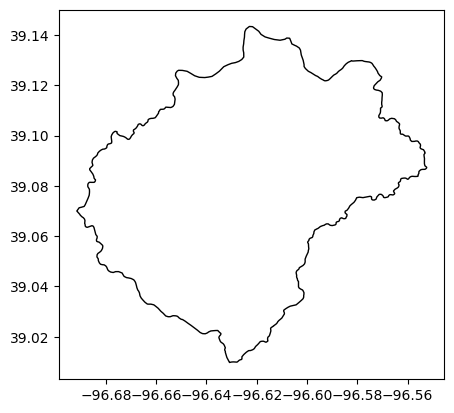

In [44]:
# Convert FeatureCollection to GeoDataFrame
gdf = gpd.GeoDataFrame.from_features([feature_info])

# Create a figure to quickly inspect the dataset
gdf.plot(facecolor='None');


In [45]:
# Save as shapefile
gdf.to_file('../outputs/kings_creek_from_gee.shp', index=False)


In [46]:
# Save as geojson using GeoPandas
gdf.to_file('../outputs/kings_creek_from_gee.geojson', driver='GeoJSON', index=False)  


### Save FeatureCollection as shapefile (Advanced)

In this case we will save a FeatureCollection with Polygon features and with GeometryCollection features, which are not supported by shapefiles. So we will need to iterate over each geometry, and only select polygons for those geometries that contain other features, like Points or LineStrings. Using geojson is recommended in this case to avoid the extra processing to fit the specifications of ESRI Shapefiles.

Ideally all the counties should be Polygons, but sometimes geometries bordering rivers or other states can result in GeometryCollections.

In [47]:
# Read US counties and filter bounds for selected region
counties = ee.FeatureCollection("TIGER/2018/Counties")

# Get FeatureCollection data
# Kansas has STATEFP number equal to 20
counties_data = counties.filter(ee.Filter.eq('STATEFP','20')).getInfo()


In [48]:
# Define coordinate reference system
wgs84 = 4326 # World Geodetic System 1984

# Convert FeatureCollection to GeoDataFrame
gdf_counties = gpd.GeoDataFrame.from_features(counties_data, crs=wgs84)
gdf_counties.head(3)


,geometry,ALAND,AWATER,CBSAFP,CLASSFP,COUNTYFP,COUNTYNS,CSAFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,LSAD,METDIVFP,MTFCC,NAME,NAMELSAD,STATEFP
0,"POLYGON ((-97.15333 37.47553, -97.15329 37.474...",2915648163,17322935,11680,H1,035,00484987,556,A,20035,+37.2345068,-096.8372468,06,,G4020,Cowley,Cowley County,20
1,"POLYGON ((-97.15347 37.82517, -97.15342 37.824...",3702816810,43671391,48620,H1,015,00484977,556,A,20015,+37.7736487,-096.8388402,06,,G4020,Butler,Butler County,20
2,"POLYGON ((-97.80760 37.47387, -97.80755 37.472...",3060429574,8589030,48620,H1,191,00481812,556,A,20191,+37.2366617,-097.4933519,06,,G4020,Sumner,Sumner County,20


In [49]:
# Find if we have features that are not polygons
gdf_counties[gdf_counties.geometry.type != 'Polygon']


,geometry,ALAND,AWATER,CBSAFP,CLASSFP,COUNTYFP,COUNTYNS,CSAFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,LSAD,METDIVFP,MTFCC,NAME,NAMELSAD,STATEFP
46,GEOMETRYCOLLECTION (LINESTRING (-96.52551 36.9...,1654694134,15243776,,H1,019,00484979,,A,20019,+37.1542592,-096.2453962,06,,G4020,Chautauqua,Chautauqua County,20
64,GEOMETRYCOLLECTION (LINESTRING (-98.34961 37.3...,2075290355,3899269,,H1,077,00485004,,A,20077,+37.1881840,-098.0665901,06,,G4020,Harper,Harper County,20
99,GEOMETRYCOLLECTION (LINESTRING (-94.87632 39.7...,1019105692,12424173,41140,H1,043,00484991,312,A,20043,+39.7885021,-095.1472253,06,,G4020,Doniphan,Doniphan County,20


In [50]:
# Let's inspect one of them to see what's inside
# Here we have a LineString and a Polygon. 
list(gdf_counties.loc[46,'geometry'].geoms)

# The shapefile will not be able to save this. Let's retain the polygon only


[<LINESTRING (-96.526 36.999, -96.526 36.999)>,
 <POLYGON ((-96.526 37.028, -96.526 37.016, -96.526 37.016, -96.526 37.008, -...>]

In [51]:
# Iterate over each row. Here we assume that there is 
# only one polygon in each row that has a GeometryCollection.
for k,row in gdf_counties.iterrows():
    
    # Check if row geometry is 'GeometryCollection'
    if row['geometry'].geom_type == 'GeometryCollection':
        
        # Iterate over each component of the GeometryCollection
        for geom in list(row['geometry'].geoms):
            
            # Overwrite geometry of row with polygon
            if geom.geom_type == 'Polygon':
                gdf_counties.loc[k,'geometry'] = geom
                
# For multiple polygons you can keep the largest one using 
# something like: max(polygons, key=lambda a: a.area)

In [52]:
# Check that we don't have any rows left that is not a polygon
# Returned GeoDataFrame should be empty
gdf_counties[gdf_counties.geometry.type != 'Polygon']


,geometry,ALAND,AWATER,CBSAFP,CLASSFP,COUNTYFP,COUNTYNS,CSAFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,LSAD,METDIVFP,MTFCC,NAME,NAMELSAD,STATEFP


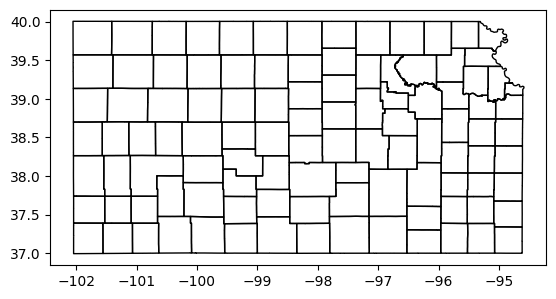

In [53]:
# Plot counties to ensure we have all of them
gdf_counties.plot(facecolor='None');

In [54]:
# Now we can save the GeoDataframe as a Shapefile
gdf_counties.to_file('../outputs/kansas_counties_from_gee.shp', index=False)
